In [52]:
import pandas as pd

model_name = "mbart50-1toM-target-ctx4-cwd0"
base_path = f"translations/scores/scat-{model_name}-scores-gen.tsv"
extra_path = f"translations/scores/temp/scat-{model_name}-scores-gen.tsv"
base_scores = pd.read_csv(base_path, sep="\t")
extra_scores = pd.read_csv(extra_path, sep="\t")

#base_scores = base_scores.iloc[:len(extra_scores)]
print(base_scores.shape, extra_scores.shape)

(10730, 31) (10515, 12)


In [53]:
out = pd.merge(base_scores, extra_scores, on=["example_idx","token_idx","token"], how="left")
out.isnull().sum()
out = out.fillna(0)
print(out.shape)
out.head()

(10730, 40)


,example_idx,token_idx,token,probability,contrast_prob,pcxmi,kl_divergence,is_supporting_context,is_context_sensitive,kl_div_10,...,kl_div_l11,src_langtag_attr,src_ctx_attr,src_brk_attr,src_curr_attr,src_eos_attr,tgt_langtag_attr,tgt_ctx_attr,tgt_brk_attr,tgt_curr_attr
0,0,0,fr_XX,0.999993,1.111782e-08,-26.422541,18.314569,0,0,17.880569,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,1,▁Son,0.556916,6.840942e-01,0.296736,1.228211,0,0,0.000000,...,0.0,0.049835,0.114247,0.070359,0.240766,0.032713,0.017222,0.113631,0.361226,0.000000
2,0,2,t,0.853989,9.875751e-01,0.209674,0.353888,0,0,0.000000,...,0.0,0.019380,0.055107,0.035376,0.101662,0.012397,0.042888,0.083949,0.144665,0.504575
3,0,3,-,0.992847,9.840391e-01,-0.012855,0.016214,0,0,0.000000,...,0.0,0.032840,0.082417,0.044509,0.130906,0.019717,0.020731,0.112503,0.132146,0.424232
4,0,4,elles,0.721416,9.907398e-01,0.457675,2.145987,0,1,0.000000,...,0.0,0.020688,0.085577,0.026818,0.082970,0.013320,0.021556,0.104236,0.085544,0.559292


In [54]:
out.to_csv(base_path, sep="\t", index=False)

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

def get_idx(use_target: bool):
    if use_target:
        return "ctx4-cwd0"
    else:
        return "ctx4-cwd1"

base_path = "translations/scores"
names = [
    "marian-small",
    "marian-big",
    "mbart50-1toM"
]

data = {}

# Load the data
for name in names:
    for use_target in [True, False]:
        model_id = f"{name}{'-target' if use_target else ''}"
        data[model_id] = pd.read_csv(f"{base_path}/scat-{model_id}-{get_idx(use_target)}-scores-gen.tsv", sep="\t")
        data[model_id]["contrast_prob_diff"] = data[model_id]["contrast_prob"] - data[model_id]["probability"]
        
# Split the data based on the condition
ctx_splits = {}
for key, df in data.items():
    curr_key = f'{key}_ctx'
    ctx_splits[curr_key] = df[df['example_idx'] < 250]
    if "mbart" in key:
        ctx_splits[curr_key] = ctx_splits[curr_key][~ctx_splits[curr_key]['token'].str.contains('fr_XX')]
    curr_key = f'{key}_no_ctx'
    ctx_splits[curr_key] = df[df['example_idx'] >= 250]
    if "mbart" in key:
        ctx_splits[curr_key] = ctx_splits[curr_key][~ctx_splits[curr_key]['token'].str.contains('fr_XX')]
print(ctx_splits.keys())

dict_keys(['marian-small-target_ctx', 'marian-small-target_no_ctx', 'marian-small_ctx', 'marian-small_no_ctx', 'marian-big-target_ctx', 'marian-big-target_no_ctx', 'marian-big_ctx', 'marian-big_no_ctx', 'mbart50-1toM-target_ctx', 'mbart50-1toM-target_no_ctx', 'mbart50-1toM_ctx', 'mbart50-1toM_no_ctx'])


In [16]:
# Define function to plot scatterplot
def plot_scatter(data, ax, title, metric='kl_divergence'):
    colors = ['red' if x else 'blue' for x in data['is_context_sensitive']]
    ax.scatter(data['token_idx'], data[metric], color=colors, alpha=0.5)
    ax.set_title(title)
    ax.set_xlabel('Token Position in Sentence')
    ax.set_ylabel(metric)

def plot_splits(plot: bool = True, metrics = ["kl_divergence", "pcxmi"]):
    row = 0
    col = 0
    max_col = 0
    for model in names:
        for use_target in [False, True]:
            for use_ctx in [True, False]:
                model_id = f"{model}{'-target' if use_target else ''}{'_ctx' if use_ctx else '_no_ctx'}"
                curr_split = ctx_splits[model_id]
                for metric in metrics:
                    if plot and metric in curr_split.columns:
                        plot_scatter(curr_split, axs[row, col], model_id + f', {metric}', metric)
                        if "prob" in metric:
                            ylim = [0, 1]
                        elif "pcxmi" in metric:
                            ylim = [-5, 10]
                        else:
                            ylim = [0, 10]
                        axs[row, col].set(xlim=[-1, 45], ylim=ylim)
                    col += 1
                    if col > max_col:
                        max_col = col
            row += 1
            col = 0
    return row, max_col

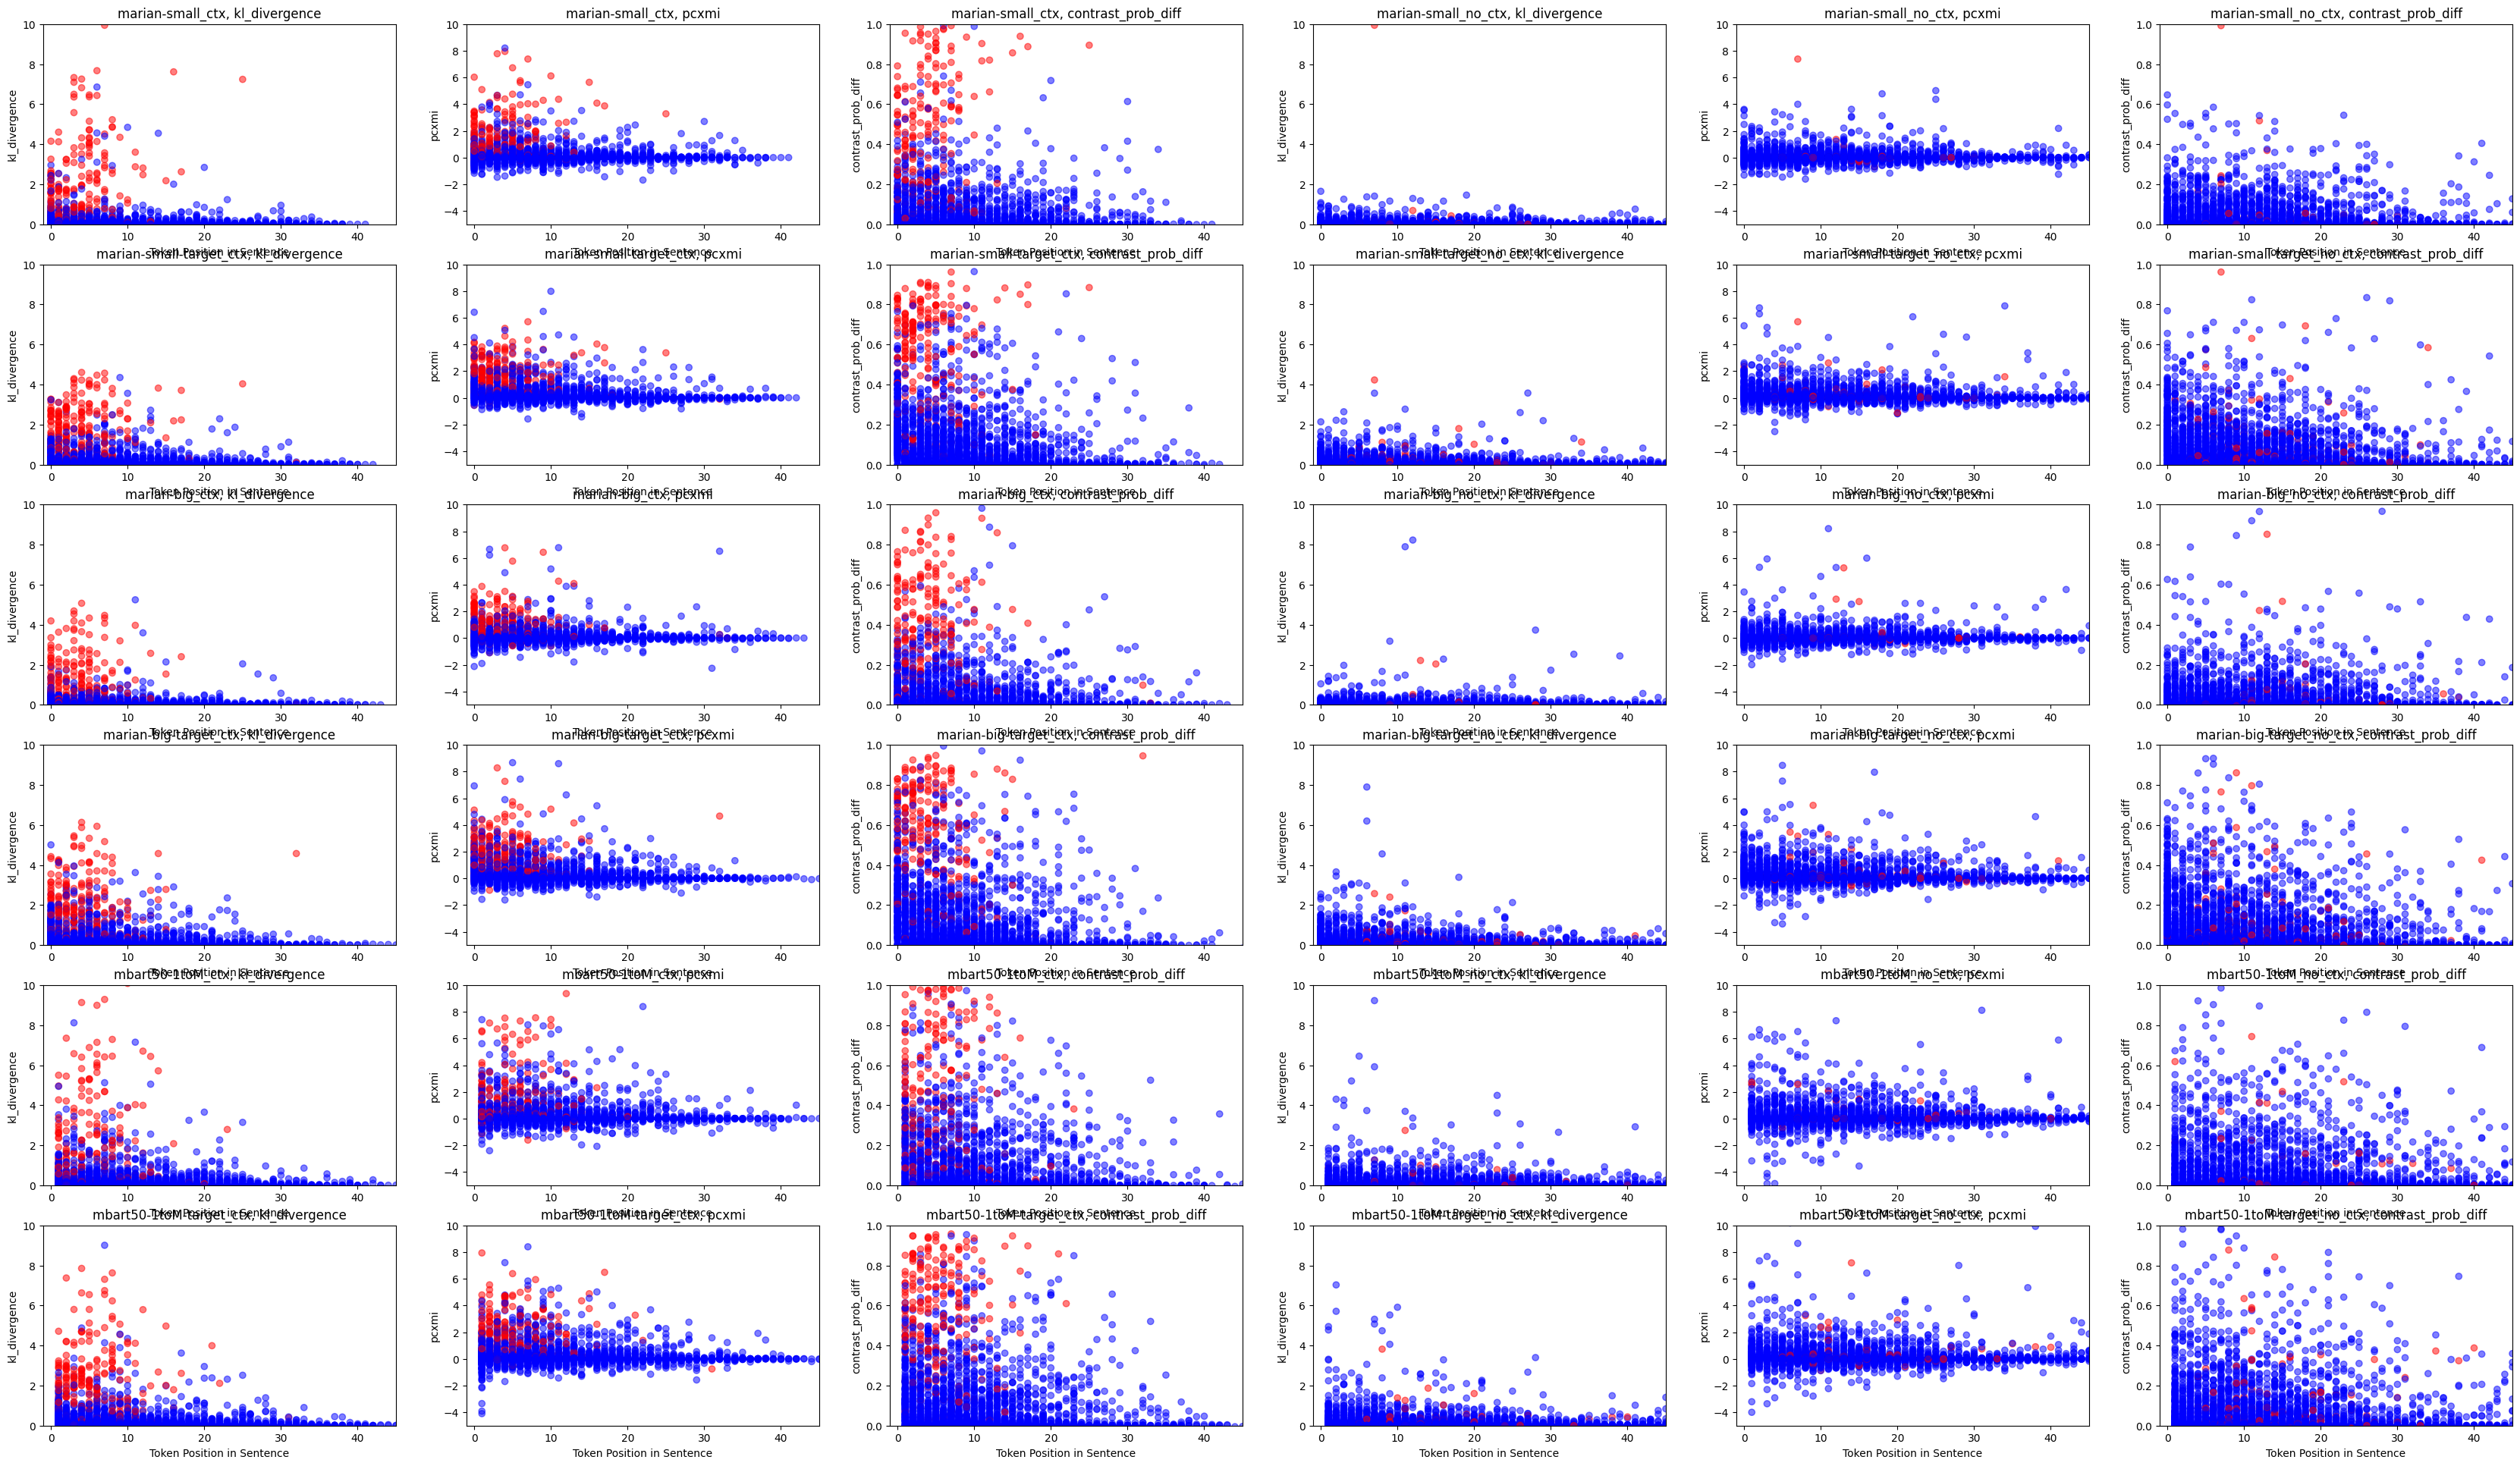

In [18]:
metrics = ["kl_divergence", "pcxmi", "contrast_prob_diff"]
#for i in range(12):
#    metrics.append(f"kl_div_l{i}")
#for m in metrics:
row, col = plot_splits(plot=False, metrics=metrics)
# Create the plots
fig, axs = plt.subplots(row, col, figsize=(7 * row, 4 * col))

# Plot the scatterplots
plot_splits(metrics=metrics)

# Show the plots
plt.show()

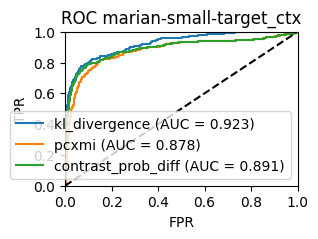

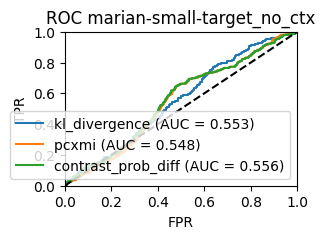

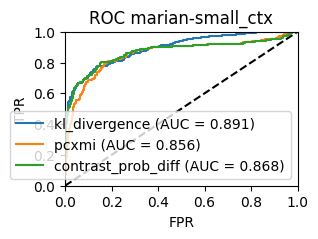

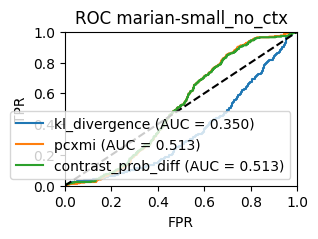

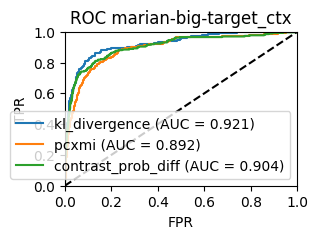

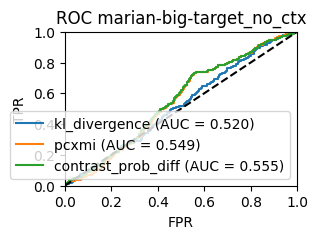

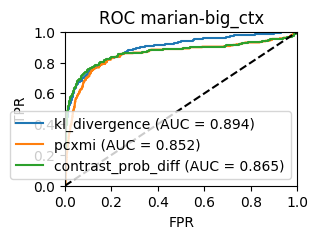

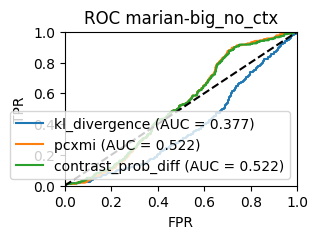

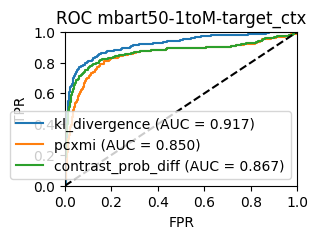

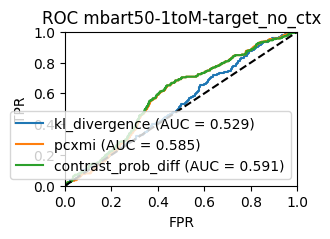

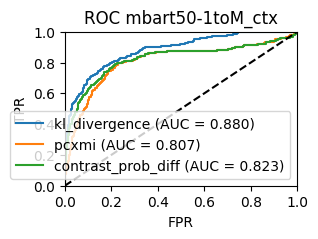

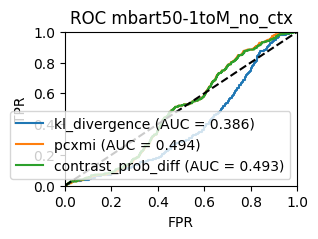

In [19]:
from sklearn.metrics import roc_auc_score, roc_curve

def plot_roc(data, name="", metrics = ['kl_divergence', 'pcxmi']):
    plt.figure(figsize=(3, 2))
    for metric in metrics:
        if metric in data.columns:
            # Calculate AUC
            auc = roc_auc_score(data['is_context_sensitive'], data[metric].fillna(0))

            # Calculate ROC curves
            fpr, tpr, _ = roc_curve(data['is_context_sensitive'], data[metric].fillna(0))

            # Create plot
            plt.plot(fpr, tpr, label=f'{metric} (AUC = {auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(f'ROC {name}')
    plt.legend(loc='lower right')
    # Show the plot
    plt.show()

metrics = ["kl_divergence", "pcxmi", "contrast_prob_diff"]
#for i in range(12):
#    metrics.append(f"kl_div_l{i}")

# Plot the ROC curves
for id, curr_data in ctx_splits.items():
    plot_roc(curr_data, id, metrics=metrics)

In [9]:
import numpy as np
from sklearn.utils import resample

# Define the number of bootstrap iterations
n_iterations = 1000

# Initialize arrays to store the bootstrap AUCs
aucs_kl = np.zeros(n_iterations)
aucs_pcxmi = np.zeros(n_iterations)

# Perform bootstrap iterations
for i in range(n_iterations):
    # Resample the data with replacement
    data_resampled = resample(data_1, n_samples=200, replace=True, random_state=i)
    
    # Calculate AUC for kl_divergence and pcxmi on the resampled data and store the values
    aucs_kl[i] = roc_auc_score(data_resampled['is_context_sensitive'], data_resampled['kl_divergence'])
    aucs_pcxmi[i] = roc_auc_score(data_resampled['is_context_sensitive'], data_resampled['pcxmi'])

# Calculate the difference between the AUCs for each iteration
diffs = aucs_kl - aucs_pcxmi

# Calculate the observed difference in AUCs on the original data
obs_diff = roc_auc_score(data_1['is_context_sensitive'], data_1['kl_divergence']) - roc_auc_score(data_1['is_context_sensitive'], data_1['pcxmi'])

# Calculate the p-value as the proportion of bootstrap differences that are greater than or equal to the observed difference
p_value = (np.sum(diffs >= obs_diff) + 1) / (n_iterations + 1)

p_value

0.44255744255744256

I.e. the difference between `kl_divergence` and `pcxmi` is not statistically significant.

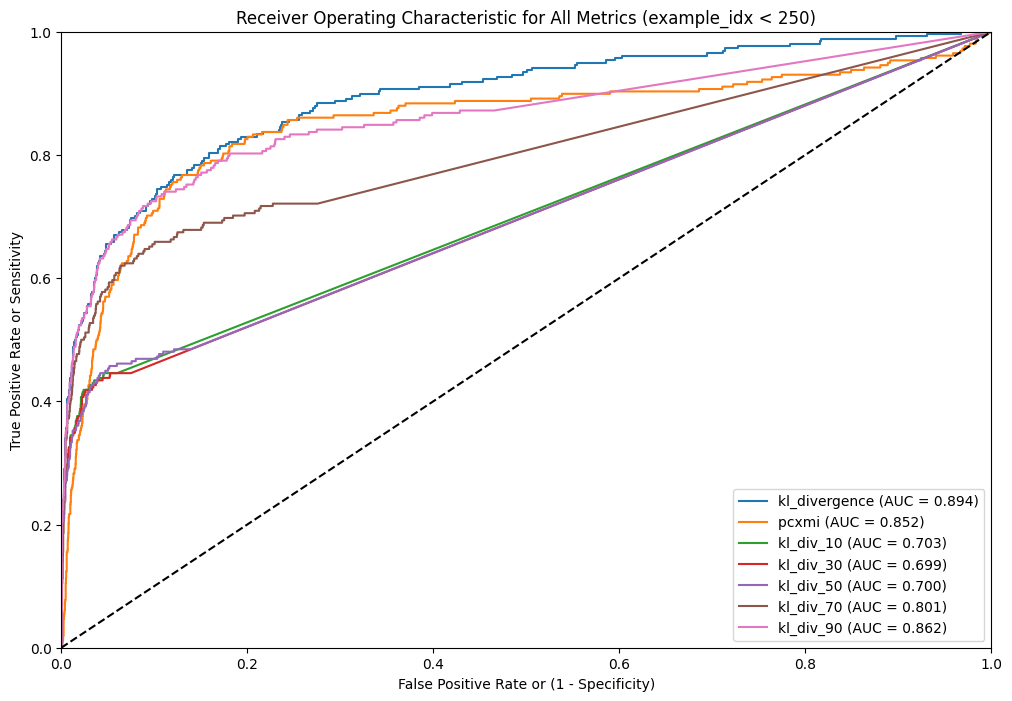

In [10]:
from sklearn.metrics import roc_auc_score, roc_curve


# Subset the data
data_subset = data_1[data_1['example_idx'] < 250]

metrics = ['kl_divergence', 'pcxmi', 'kl_div_10', 'kl_div_30', 'kl_div_50', 'kl_div_70', 'kl_div_90']

# Initialize plot
plt.figure(figsize=(12, 8))

# Calculate and plot ROC curve for each metric
for metric in metrics:
    fpr, tpr, _ = roc_curve(data_subset['is_context_sensitive'], data_subset[metric])
    auc = roc_auc_score(data_subset['is_context_sensitive'], data_subset[metric])
    plt.plot(fpr, tpr, label=f'{metric} (AUC = {auc:.3f})')

# Plot ROC curve for random predictions
plt.plot([0, 1], [0, 1], 'k--')

# Set plot labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specificity)')
plt.ylabel('True Positive Rate or Sensitivity')
plt.title('Receiver Operating Characteristic for All Metrics (example_idx < 250)')
plt.legend(loc='lower right')

# Show the plot
plt.show()


In [18]:
import pandas as pd
import numpy as np

# Recreate the data subset
data_subset = data[data['example_idx'] < 250]
data_subset["abs_pcxmi"] = abs(data_subset["pcxmi"])

# Calculate the correlation between kl_divergence and pcxmi
correlation = data_subset[['kl_divergence', 'abs_pcxmi']].corr().iloc[0, 1]

# Create a new column for the disagreement between kl_divergence and pcxmi
# We will consider that they disagree when the difference in their rankings is greater than the median difference
data_subset = data_subset.copy()  # to avoid SettingWithCopyWarning
data_subset['kl_rank'] = data_subset.groupby('example_idx')['kl_divergence'].rank()
data_subset['pcxmi_rank'] = data_subset.groupby('example_idx')['abs_pcxmi'].rank()
data_subset['rank_diff'] = abs(data_subset['kl_rank'] - data_subset['pcxmi_rank'])

data_subset['disagreement'] = data_subset['rank_diff'] > 8

# Select the example_idx values where there is a disagreement
disagree_examples = data_subset[data_subset['disagreement']]['example_idx'].unique()

# Randomly select 5 examples where there is a disagreement
selected_examples = np.random.choice(disagree_examples, size=5, replace=False)

# Get the data for the selected examples
selected_data = data_subset[data_subset['example_idx'].isin(selected_examples)]

print("Correlation:", correlation)

# Print the data for the selected examples
selected_data[["example_idx", "token", "abs_pcxmi", "kl_divergence", "kl_rank", "pcxmi_rank", "rank_diff", "disagreement"]].to_csv("select.tsv", sep="\t", index=False)


Correlation: 0.7547211431366712


/tmp/ipykernel_196504/1007134304.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset["abs_pcxmi"] = abs(data_subset["pcxmi"])


In [29]:
from sklearn.linear_model import LogisticRegression

# Select features for the model
features = ['kl_divergence']#['pcxmi', 'kl_divergence', 'top_p_size_10', 'top_p_size_30', 'top_p_size_50', 'top_p_size_70', 'top_p_size_90', 'token_idx']

# Prepare data for the model
X = data_subset[features]
y = data_subset['is_context_sensitive']

# Initialize and fit the logistic regression model
model = LogisticRegression(solver='liblinear')
model.fit(X, y)

# Get the coefficients of the model
coefficients = model.coef_[0]

# Create a DataFrame to display the features and their corresponding coefficients
coef_df = pd.DataFrame({'feature': features, 'coefficient': coefficients})

coef_df


,feature,coefficient
0,kl_divergence,1.913497


In [34]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation on the logistic regression model
scores = cross_val_score(model, X, y, cv=100, scoring='accuracy')

# Compute the mean and standard deviation of the scores
mean_score = np.mean(scores)
std_score = np.std(scores)

mean_score, std_score

(0.9497307692307695, 0.026702266055370297)

In [ ]:
def get_mean_std_scores(data):
    # Create two subsets
    inter_subset = data[data['example_idx'] < 250]
    intra_subset = data[data['example_idx'] >= 250]

    # Create four subsets based on the given conditions
    inter_sensitive = inter_subset[inter_subset['is_context_sensitive'] == 1]
    inter_nonsensitive = inter_subset[inter_subset['is_context_sensitive'] == 0]
    intra_sensitive = intra_subset[intra_subset['is_context_sensitive'] == 1]
    intra_nonsensitive = intra_subset[intra_subset['is_context_sensitive'] == 0]

    # Calculate mean and standard deviation for these four subsets
    inter_sensitive_pcxmi = f"{inter_sensitive['pcxmi'].mean():.2f} ± {inter_sensitive['pcxmi'].std():.2f}"
    inter_sensitive_kl = f"{inter_sensitive['kl_divergence'].mean():.2f} ± {inter_sensitive['kl_divergence'].std():.2f}"
    inter_nonsensitive_pcxmi = f"{inter_nonsensitive['pcxmi'].mean():.2f} ± {inter_nonsensitive['pcxmi'].std():.2f}"
    inter_nonsensitive_kl = f"{inter_nonsensitive['kl_divergence'].mean():.2f} ± {inter_nonsensitive['kl_divergence'].std():.2f}"

    intra_sensitive_pcxmi = f"{intra_sensitive['pcxmi'].mean():.2f} ± {intra_sensitive['pcxmi'].std():.2f}"
    intra_sensitive_kl = f"{intra_sensitive['kl_divergence'].mean():.2f} ± {intra_sensitive['kl_divergence'].std():.2f}"
    intra_nonsensitive_pcxmi = f"{intra_nonsensitive['pcxmi'].mean():.2f} ± {intra_nonsensitive['pcxmi'].std():.2f}"
    intra_nonsensitive_kl = f"{intra_nonsensitive['kl_divergence'].mean():.2f} ± {intra_nonsensitive['kl_divergence'].std():.2f}"

    # Create a dictionary to hold these values
    data_dict_subcategories = {
        'Subset': ['Inter-Sensitive', 'Inter-Non-sensitive', 'Intra-Sensitive', 'Intra-Non-sensitive'],
        'pcxmi': [inter_sensitive_pcxmi, inter_nonsensitive_pcxmi, intra_sensitive_pcxmi, intra_nonsensitive_pcxmi],
        'KL Divergence': [inter_sensitive_kl, inter_nonsensitive_kl, intra_sensitive_kl, intra_nonsensitive_kl],
    }

    # Convert the dictionary into a DataFrame
    df_subcategories = pd.DataFrame(data_dict_subcategories)

    # Convert the DataFrame to a LaTeX table
    latex_table_subcategories = df_subcategories.to_latex(index=False, escape=False)

    return latex_table_subcategories



In [48]:
import pandas as pd
import numpy as np
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

def feat_importance(df):
    # Filter the columns to include only float type
    float_columns = df.select_dtypes(include=['float64']).columns
    # Define our predictors and target for the sampled data
    X_sample = df[float_columns]
    y_sample = df['is_context_sensitive']

    # Scale our data
    scaler = StandardScaler()
    X_sample_scaled = scaler.fit_transform(X_sample)

    # Create a base classifier using Logistic Regression
    logreg = LogisticRegression(random_state=42, max_iter=200)

    # RFECV with Logistic Regression
    rfecv = RFECV(estimator=logreg, step=1, cv=StratifiedKFold(5), scoring='f1_macro')
    rfecv.fit(X_sample_scaled, y_sample)

    # Get the selected features
    selected_columns = list(float_columns[rfecv.support_])
    for col in selected_columns:
        print(col)
    return selected_columns

def get_results(df: pd.DataFrame, columns=None, do_random: bool = False, verbose: bool = False):
    # Features and target for the updated DataFrame
    X = df[columns].to_numpy()
    y = df['is_context_sensitive'].to_numpy()

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    # Train the classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    dummy = DummyClassifier(strategy='stratified', random_state=42)

    # Capture the feature importances across folds
    feature_importances = []
    f1_scores = []

    # Enumerate the splits and summarize the distributions
    for train_ix, test_ix in cv.split(X, y):

        # split data
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y[train_ix], y[test_ix]

        # It's usually a good practice to scale our data, as many machine learning 
        # models perform better on scaled data, especially when they use distance-based metrics.
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        if not do_random:
            clf.fit(X_train_scaled, y_train)

            # predict on the test set
            y_pred = clf.predict(X_test)

            # get feature importances
            feature_importances.append(clf.feature_importances_)
        else:
            dummy.fit(X_train_scaled, y_train)
            y_pred = dummy.predict(X_test)
        
        # get classification report
        f1 = f1_score(y_test, y_pred, average="macro")
        f1_scores.append(f1)
    
    # Average classification report across folds
    print('Avg Macro F1: ', np.mean(f1_scores))

    if feature_importances and verbose:
        # Average feature importance across folds
        average_importance = np.mean(feature_importances, axis=0)

        # Print the sorted feature ranking
        print("Feature ranking:")
        sorted_idx = list(average_importance.argsort())
        for i, idx in enumerate(sorted_idx[::-1], start=1):
            print(f"{i}. {columns[idx]} ({average_importance[idx]:.4f})")

In [49]:
# Reload the data
model_name = "mbart50-1toM-ctx4-cwd1"#"marian-big-ctx4-cwd1"#"mbart50-1toM-ctx4-cwd1"
df = pd.read_csv(f'translations/scores/scat-{model_name}-scores-gen.tsv', sep='\t')

# Add the new columns to the DataFrame
df["contrast_prob_diff"] = df["contrast_prob"] - df["probability"]
df_filled = df.fillna(df.mean())

scat_cs = df_filled["example_idx"] < 250
scat_ci = df_filled["example_idx"] >= 250
scat_ok = df_filled["is_correct"] == 1
scat_bad = df_filled["is_correct"] == 0
scat_cs_ok = (df_filled["example_idx"] < 250) & (df_filled["is_correct"] == 1)
scat_ci_ok = (df_filled["example_idx"] >= 250) & (df_filled["is_correct"] == 1)
scat_cs_bad = (df_filled["example_idx"] < 250) & (df_filled["is_correct"] == 0)
scat_ci_bad = (df_filled["example_idx"] >= 250) & (df_filled["is_correct"] == 0)

folds = {
    "scat_cs_ok": df_filled[scat_cs_ok],
    "scat_cs_bad": df_filled[scat_cs_bad],
    "scat_cs_all": df_filled[scat_cs],
    "scat_ci_ok": df_filled[scat_ci_ok],
    "scat_ci_bad": df_filled[scat_ci_bad],
    "scat_ci_all": df_filled[scat_ci],
    "scat_ok": df_filled[scat_ok],
    "scat_bad": df_filled[scat_bad],
    "scat_all": df_filled
}

/tmp/ipykernel_10096/4001485563.py:7: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_filled = df.fillna(df.mean())


In [ ]:
for split_name, split in folds.items():
    print(split_name, split.is_context_sensitive.sum(), len(split), round(split.is_context_sensitive.sum() / len(split), 2))
    print(split_name, split.groupby("example_idx").mean().is_correct.sum())

In [ ]:
feats = feat_importance(df_filled)
get_results(df_filled, feats, verbose=True)

In [ ]:
csi_mix_cols = ["kl_divergence", "src_ctx_attr", "contrast_prob_diff", "contrast_prob", "src_curr_attr"] + [f"kl_div_l{i}" for i in range(12)]
#csi_mix_cols = ["kl_div_l11", "kl_divergence", "src_ctx_attr", "contrast_prob_diff", "kl_div_l10", "contrast_prob", "src_curr_attr", "kl_div_l9"]

for split_name, split in folds.items():
    print("###", split_name, "###")
    print("\nRandom:")
    get_results(split, ["probability"], do_random=True)
    print("\nP-CXMI:")
    get_results(split, ["pcxmi"])
    #print("\nContrast probability:")
    #get_results(split, ["contrast_prob"])
    #print("\nKL divergence:")
    #get_results(split, ["kl_divergence"])
    print("\nCSI mix:")
    get_results(split, csi_mix_cols)
    print("=" * 30)


In [9]:
import datasets

d = datasets.load_dataset("inseq/disc_eval_mt", "lexical-choice")

In [10]:
d

DatasetDict({
    test: Dataset({
        features: ['id', 'context_en', 'en', 'context_fr', 'fr', 'contrast_fr', 'context_en_with_tags', 'en_with_tags', 'context_fr_with_tags', 'fr_with_tags', 'contrast_fr_with_tags', 'type'],
        num_rows: 200
    })
})

In [22]:
with open("lexical-choice.contrast.fr", "w") as f:
    f.write("\n".join(d["test"]["contrast_fr_with_tags"]))

250


,example_idx,token_idx,token,probability,contrast_prob,contrast_prob_diff,pcxmi,kl_divergence,kl_div_10,top_p_size_10,...,kl_div_l4,kl_div_l5,src_ctx_attr,src_brk_attr,src_curr_attr,src_eos_attr,tgt_curr_attr,is_supporting_context,is_context_sensitive,is_example_correct
0,0,0,▁Elles,0.1341,0.8478,-0.7136,2.6599,1.8305,1.5445,1.0,...,0.0010,0.0184,0.2837,0.2119,0.4024,0.1019,0.0000,0,1,1
1,0,1,▁sont,0.8288,0.7636,0.0652,-0.1182,0.0308,0.0000,1.0,...,0.0827,0.0067,0.2134,0.2425,0.2820,0.1020,0.1601,0,0,1
2,0,2,▁à,0.7773,0.8916,-0.1143,0.1979,0.0633,0.0000,1.0,...,0.0256,0.1839,0.1490,0.1128,0.3429,0.0894,0.3059,0,0,1
3,0,3,▁l,0.9919,0.9939,-0.0020,0.0030,0.0010,0.0000,1.0,...,0.0150,0.0004,0.1268,0.1201,0.4083,0.0669,0.2779,0,0,1
4,0,4,',0.9969,0.9985,-0.0016,0.0022,0.0009,0.0000,1.0,...,0.0032,0.0005,0.1395,0.0877,0.1533,0.0309,0.5886,0,0,1


In [21]:
test_fname = "scat-marian-small-scat-cti"
df_test = pd.read_csv(f'../outputs/scores/scat/{test_fname}.tsv', sep='\t')
df_test_scat = df_test[df_test["example_idx"] < 250]
num_ex_test = len(df_test_scat["example_idx"].unique())
print(num_ex_test)
df_test_scat.head()

250


,example_idx,token_idx,token,probability,contrast_prob,contrast_prob_diff,pcxmi,kl_divergence,kl_div_10,top_p_size_10,...,kl_div_l4,kl_div_l5,src_ctx_attr,src_brk_attr,src_curr_attr,src_eos_attr,tgt_curr_attr,is_supporting_context,is_context_sensitive,is_example_correct
0,0,0,▁Elles,0.0921,0.4565,-0.3644,2.3088,0.8516,0.0,1.0,...,0.0000,0.0008,0.2317,0.1883,0.3667,0.2134,0.0000,0,1,1
1,0,1,▁sont,0.9803,0.9664,0.0140,-0.0207,0.0168,0.0,1.0,...,0.0093,0.0072,0.2964,0.1678,0.2115,0.1137,0.2105,0,0,1
2,0,2,▁à,0.8295,0.8786,-0.0491,0.0830,0.0844,0.0,1.0,...,0.0060,0.0124,0.1919,0.1264,0.3002,0.1259,0.2556,0,0,1
3,0,3,▁l,0.9385,0.9625,-0.0240,0.0364,0.0095,0.0,1.0,...,0.0031,0.0035,0.1802,0.0791,0.2604,0.1221,0.3583,0,0,1
4,0,4,',0.9954,0.9941,0.0013,-0.0019,0.0002,0.0,1.0,...,0.0027,0.0011,0.1930,0.0964,0.2365,0.1074,0.3668,0,0,1


In [10]:
from pecore.analysis_utils import get_cti_mix_features, mrr, dot
from sklearn.metrics import f1_score, precision_recall_curve, auc
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import warnings
from tqdm.notebook import tqdm

from typing import Union, Optional


def compute_full_scores(
    clf: Union[RandomForestClassifier, DummyClassifier],
    df_train: pd.DataFrame,
    df_test: pd.DataFrame,
    score_columns: list,
    target_column: str,
    fillna: bool = True,
) -> dict:
    if fillna:
        df_train = df_train.fillna(df_train.mean(numeric_only=True))
        df_test = df_test.fillna(df_test.mean(numeric_only=True))

    X_train = df_train[score_columns].to_numpy()
    y_train = df_train[target_column].to_numpy()
    X_test = df_test[score_columns].to_numpy()
    y_test = df_test[target_column].to_numpy()

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    predicted_proba = clf.predict_proba(X_test_scaled)[:, 1]

    # get classification report
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        f1 = f1_score(y_test, y_pred, average="macro")
        precision, recall, _ = precision_recall_curve(y_test, predicted_proba)
        auprc = auc(recall, precision)
        per_example_f1 = []
        per_example_auprc = []
        per_example_mrr = []
        per_example_dot = []
        start_idx = 0
        test_ex_ids = df_test["example_idx"].unique()
        for ex_id in test_ex_ids:
            df_ex = df_test[df_test["example_idx"] == ex_id]
            num_tokens = len(df_ex)
            if num_tokens == 0:
                continue
            end_idx = start_idx + num_tokens
            tok_ex = " ".join(list(df_test["token"].iloc[start_idx:end_idx]))
            y_ex = y_test[start_idx:end_idx]
            y_pred_ex = y_pred[start_idx:end_idx]
            predicted_proba_ex = predicted_proba[start_idx:end_idx]
            per_example_f1.append(f1_score(y_ex, y_pred_ex, average="macro"))
            precision_ex, recall_ex, _ = precision_recall_curve(y_ex, predicted_proba_ex)
            per_example_auprc.append(auc(recall_ex, precision_ex))
            per_example_mrr.append(mrr(y_ex, predicted_proba_ex))
            per_example_dot.append(dot(y_ex, predicted_proba_ex))
            start_idx = end_idx
    return {
        "macro_f1": f1,
        "auprc": auprc,
        "per_example_f1": per_example_f1,
        "per_example_auprc": per_example_auprc,
        "per_example_mrr": per_example_mrr,
        "per_example_dot": per_example_dot,
    }


def compute_cv_scores(
    clf: Union[RandomForestClassifier, DummyClassifier],
    df_train: pd.DataFrame,
    df_test: pd.DataFrame,
    score_columns: list,
    target_column: str,
    cv_folds: int,
    verbose: bool = True,
) -> dict:

    num_ex = len(df_test["example_idx"].unique())
    step = num_ex // cv_folds

    full_f1_scores = []
    full_auprc_scores = []
    f1_scores = []
    auprc_scores = []
    mrr_scores = []
    dot_scores = []

    for i in tqdm(range(0, num_ex, step), total=(num_ex // step), disable=not verbose):
        ex_range = list(range(i, i + step))
        train = df_train[df_train["example_idx"].isin(ex_range)]
        test = df_test[~df_test["example_idx"].isin(ex_range)]
        dict_scores = compute_full_scores(
            clf,
            train,
            test,
            score_columns,
            target_column,
        )
        full_f1_scores.append(dict_scores["macro_f1"])
        full_auprc_scores.append(dict_scores["auprc"])
        f1_scores.extend(dict_scores["per_example_f1"])
        auprc_scores.append(dict_scores["per_example_auprc"])
        mrr_scores.append(dict_scores["per_example_mrr"])
        dot_scores.append(dict_scores["per_example_dot"])

    return {
        "avg_full_macro_f1": np.mean(full_f1_scores).round(4),
        "std_full_macro_f1": np.std(full_f1_scores).round(4),
        "avg_full_auprc": np.mean(full_auprc_scores).round(4),
        "std_full_auprc": np.std(full_auprc_scores).round(4),
        "avg_macro_f1": np.mean(f1_scores).round(4),
        "std_macro_f1": np.std(f1_scores).round(4),
        "avg_auprc": np.mean(auprc_scores).round(4),
        "std_auprc": np.std(auprc_scores).round(4),
        "avg_mrr": np.nanmean(mrr_scores).round(4),
        "std_mrr": np.nanstd(mrr_scores).round(4),
        "avg_dot": np.mean(dot_scores).round(4),
        "std_dot": np.std(dot_scores).round(4),
    }


def compute_scores(
    train_fname : str,
    train_type: str,
    test_fname: Optional[str] = None,
    test_type: Optional[str] = None,
    cv_folds: int = 10,
    seed: int = 42,
    score_columns: list = None,
    do_random: bool = False,
    use_test_df: bool = False,
    target_column: str = "is_context_sensitive",
    n_layers_train: int = 6,
    has_target_context_train: bool = False,
    verbose: bool = True,
) -> dict:
    # Use CTI-Mix as default features if not specified
    if score_columns is None and target_column == "is_context_sensitive":
        score_columns = get_cti_mix_features(n_layers_train, has_target_context_train)
    elif score_columns == "all":
        score_columns = df.select_dtypes('number')

    df_train = pd.read_csv(f'../outputs/scores/{train_type}/{train_fname}.tsv', sep='\t')
    if train_type == "scat":
        df_train = df_train[df_train["example_idx"] < 250]
    if use_test_df:
        df_test = pd.read_csv(f'../outputs/scores/{test_type}/{test_fname}.tsv', sep='\t')
        if test_type == "scat":
            df_test = df_test[df_test["example_idx"] < 250]
    
    clf = RandomForestClassifier(random_state=seed, class_weight="balanced")
    dummy = DummyClassifier(strategy="stratified", random_state=seed)

    if test_type is None or train_type == test_type:
        return compute_cv_scores(
            clf if not do_random else dummy,
            df_train,
            df_test if use_test_df else df_train,
            score_columns,
            target_column,
            cv_folds,
            verbose=verbose,
        )
    else:
        if not use_test_df:
            raise ValueError("Cannot use train df if train_type != test_type")
        out = compute_full_scores(
            clf if not do_random else dummy,
            df_train,
            df_test,
            score_columns,
            target_column,
        )
        return {
            "avg_macro_f1": np.mean(out["per_example_f1"]).round(4),
            "std_macro_f1": np.std(out["per_example_f1"]).round(4),
            "avg_auprc": np.mean(out["per_example_auprc"]).round(4),
            "std_auprc": np.std(out["per_example_auprc"]).round(4),
            "avg_mrr": np.nanmean(out["per_example_mrr"]).round(4),
            "std_mrr": np.nanstd(out["per_example_mrr"]).round(4),
            "avg_dot": np.mean(out["per_example_dot"]).round(4),
            "std_dot": np.std(out["per_example_dot"]).round(4),
        }

In [ ]:
from pprint import pprint

print("10-fold CV of small on SCAT")
out = compute_scores(
    train_fname="scat-marian-small-scat-cti",
    train_type="scat",
    score_columns=None, # CTI-Mix
    use_test_df=False,
    n_layers_train=6,
    has_target_context_train=False,
)
pprint(out)

print("10-fold CV of small on SCAT - KL-Div")
out = compute_scores(
    train_fname="scat-marian-small-scat-cti",
    train_type="scat",
    score_columns=["kl_divergence"],
    use_test_df=False,
    n_layers_train=6,
    has_target_context_train=False,
)
pprint(out)

print("Cross train small -> test big on SCAT")
out = compute_scores(
    train_fname="scat-marian-small-scat-cti",
    test_fname="scat-marian-big-scat-cti",
    train_type="scat",
    test_type="scat",
    score_columns=None, # CTI-Mix
    use_test_df=True,
    n_layers_train=6,
    has_target_context_train=False,
)
pprint(out)

print("10-fold CV of small on DiscEval-MT")
out = compute_scores(
    train_fname="disc_eval_mt-anaphora-marian-small-scat-cti",
    train_type="disc_eval_mt/anaphora",
    score_columns=None, # CTI-Mix
    use_test_df=False,
    n_layers_train=6,
    has_target_context_train=False,
)
pprint(out)

print("Cross train small -> test big on DiscEval-MT")
out = compute_scores(
    train_fname="disc_eval_mt-anaphora-marian-small-scat-cti",
    test_fname="disc_eval_mt-anaphora-marian-big-scat-cti",
    train_type="disc_eval_mt/anaphora",
    test_type="disc_eval_mt/anaphora",
    score_columns=None, # CTI-Mix
    use_test_df=True,
    n_layers_train=6,
    has_target_context_train=False,
)
pprint(out)


In [ ]:
print("Cross train small SCAT -> test small DiscEval-MT")
out = compute_scores(
    train_fname="scat-marian-small-scat-cti",
    test_fname="disc_eval_mt-lexical-choice-marian-small-scat-cti",
    train_type="scat",
    test_type="disc_eval_mt/lexical-choice",
    score_columns=None, # CTI-Mix
    use_test_df=True,
    n_layers_train=6,
    has_target_context_train=False,
)
pprint(out)

In [ ]:
out = compute_scores(
    train_fname="scat-marian-small-scat-cti",
    test_fname="disc_eval_mt-lexical-choice-marian-small-scat-cti",
    train_type="scat",
    test_type="disc_eval_mt/lexical-choice",
    score_columns=["kl_divergence"],
    use_test_df=True,
    n_layers_train=6,
    has_target_context_train=False,
)
pprint(out)

In [5]:
from tqdm.notebook import tqdm
import pandas as pd

scores_map = {
    "cti_mix": None,
    "random": None,
    "kl_divergence": ["kl_divergence"],
    "pcxmi": ["pcxmi"],
}

all_outs = []
with tqdm(total=(3 * 3 * 3 * 3 * 4), position=0) as pbar:
    for train_model in ["marian-small", "marian-big", "mbart50-1toM"]:
        for test_model in ["marian-small", "marian-big", "mbart50-1toM"]:
            for train_type in ["scat", "disc_eval_mt/anaphora", "disc_eval_mt/lexical-choice"]:
                for test_type in ["scat", "disc_eval_mt/anaphora", "disc_eval_mt/lexical-choice"]:
                    for score in scores_map.keys():
                        out = compute_scores(
                            train_fname=f"{train_type.replace('/', '-')}-{train_model}-scat-target-cti",
                            test_fname=f"{test_type.replace('/', '-')}-{test_model}-scat-target-cti",
                            train_type=train_type,
                            test_type=test_type,
                            score_columns=scores_map[score],
                            use_test_df=True,
                            n_layers_train=12 if train_model == "mbart50-1toM" and test_model == "mbart50-1toM" else 6,
                            has_target_context_train=True,
                            do_random=score == "random",
                            verbose=False,
                        )
                        out["train_model"] = train_model + "-target"
                        out["test_model"] = test_model + "-target"
                        out["train_type"] = train_type.replace("/", "-")
                        out["test_type"] = test_type.replace("/", "-")
                        out["score"] = score
                        all_outs.append(out)
                        pbar.update(1)
            df = pd.DataFrame(all_outs)
            df.to_csv("../outputs/metrics_evals/random_forest_performance_full.tsv", sep="\t", index=False)

df = pd.DataFrame(all_outs)
df.to_csv("../outputs/metrics_evals/random_forest_performance_full.csv", sep="\t", index=False)
            

In [8]:
df = pd.DataFrame(all_outs)
df = df[["train_model", "test_model", "train_type", "test_type", "score", "avg_macro_f1", "avg_auprc", "avg_mrr", "avg_dot", "std_macro_f1", "std_auprc", "std_mrr", "std_dot", "avg_full_macro_f1", "avg_full_auprc", "std_full_macro_f1", "std_full_auprc"]]
df.to_csv("../outputs/metrics_evals/random_forest_performance_full.tsv", sep="\t", index=False)

In [ ]:
from pprint import pprint

print("10-fold CV of small on SCAT")
out = compute_scores(
    train_fname="scat-marian-small-scat-cti",
    train_type="scat",
    score_columns=None, # CTI-Mix
    use_test_df=False,
    n_layers_train=6,
    has_target_context_train=False,
    do_random=True,
)
pprint(out)

In [1]:
from datasets import load_dataset

dataset = load_dataset("GroNLP/divemt", "main")
df = dataset["train"].to_pandas()
df.head()

,unit_id,flores_id,item_id,subject_id,lang_id,doc_id,task_type,translation_type,src_len_chr,mt_len_chr,...,tgt_text,aligned_edit,src_tokens,src_annotations,mt_tokens,mt_annotations,tgt_tokens,tgt_annotations,src_wmt22_qe,mt_wmt22_qe
0,flores101-main-tur-1-ht-1,205,flores101-main-11,tur_t1,tur,1,ht,ht,155,NaN,...,2010 depreminden sonra Haiti'ye giden BM arabu...,nan,"[UN, peacekeepers, ,, whom, arrived, in, Haiti...","{'lemma': ['UN', 'peacekeeper', ',', 'whom', '...",[],"{'lemma': [], 'upos': [], 'feats': [], 'head':...","[2010, depreminden, sonra, Haiti'ye, giden, BM...","{'lemma': ['2010', 'deprem', 'sonra', 'Haiti',...",[],[]
1,flores101-main-tur-1-ht-2,206,flores101-main-12,tur_t1,tur,1,ht,ht,165,NaN,...,"Davaya göre, BM kampının doğru biçimde sterili...",nan,"[According, to, the, lawsuit, ,, waste, from, ...","{'lemma': ['accord', 'to', 'the', 'lawsuit', '...",[],"{'lemma': [], 'upos': [], 'feats': [], 'head':...","[Davaya, göre, ,, BM, kampının, doğru, biçimde...","{'lemma': ['dava', 'göre', ',', 'Bm', 'kamp', ...",[],[]
2,flores101-main-tur-1-ht-3,207,flores101-main-13,tur_t1,tur,1,ht,ht,106,NaN,...,Bu ekip gelmeden önce Haiti'de 1800'lerden ber...,nan,"[Prior, to, the, arrival, of, troops, ,, Haiti...","{'lemma': ['prior', 'to', 'the', 'arrival', 'o...",[],"{'lemma': [], 'upos': [], 'feats': [], 'head':...","[Bu, ekip, gelmeden, önce, Haiti'de, 1800'lerd...","{'lemma': ['bu', 'ekip', 'gel', 'önce', 'Haiti...",[],[]
3,flores101-main-tur-1-ht-4,208,flores101-main-14,tur_t1,tur,1,ht,ht,176,NaN,...,Haiti'deki Institute for Justice and Democracy...,nan,"[The, Haitian, Institute, for, Justice, and, D...","{'lemma': ['the', 'Haitian', 'Institute', 'for...",[],"{'lemma': [], 'upos': [], 'feats': [], 'head':...","[Haiti'deki, Institute, for, Justice, and, Dem...","{'lemma': ['Haiti+ki', 'Institute', 'for', 'Ju...",[],[]
4,flores101-main-tur-1-ht-5,209,flores101-main-15,tur_t1,tur,1,ht,ht,105,NaN,...,BM'nin hastalık konusundaki uzmanlarından biri...,nan,"[Danielle, Lantagne, ,, a, UN, expert, on, the...","{'lemma': ['Danielle', 'Lantagne', ',', 'a', '...",[],"{'lemma': [], 'upos': [], 'feats': [], 'head':...","[BM'nin, hastalık, konusundaki, uzmanlarından,...","{'lemma': ['Bm', 'hastalık', 'konu+ki', 'uzman...",[],[]


In [2]:
import subprocess
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_id = "facebook/mbart-large-50-one-to-many-mmt"
model = AutoModelForSeq2SeqLM.from_pretrained(model_id).to("cuda")
tok = AutoTokenizer.from_pretrained(model_id, src_lang="en_XX", tgt_lang="nl_XX")

single_df = df[(df["lang_id"] == "ita") & (df["subject_id"] == "ita_t4")]
for doc_id in list(single_df.doc_id.unique()):
    doc_df = single_df[single_df["doc_id"] == doc_id]
    flores_ids = sorted(list(doc_df.flores_id.unique()))
    if len(flores_ids) > 1:
        pos = 1
        #for pos in range(1, len(flores_ids)):
        ctx = " ".join(doc_df[doc_df["flores_id"] == flores_prev_idx]["src_text"].iloc[0] for flores_prev_idx in flores_ids[:pos])
        curr = doc_df[doc_df["flores_id"] == flores_ids[pos]]["src_text"].iloc[0]
        model_inputs = tok(f"{ctx} {curr}", return_tensors="pt")
        model_inputs = {k: v.to("cuda") for k, v in model_inputs.items()}
        output = model.generate(**model_inputs, forced_bos_token_id=tok.lang_code_to_id[tok.tgt_lang])
        out_sent = tok.batch_decode(output, skip_special_tokens=True)[0]
        del model_inputs
        torch.cuda.empty_cache()
        model_inputs = tok(curr, return_tensors="pt")
        model_inputs = {k: v.to("cuda") for k, v in model_inputs.items()}
        output_current = model.generate(**model_inputs, forced_bos_token_id=tok.lang_code_to_id[tok.tgt_lang])
        out_current_sent = tok.batch_decode(output_current, skip_special_tokens=True)[0]
        del model_inputs
        torch.cuda.empty_cache()
        model_inputs = tok(ctx, return_tensors="pt")
        model_inputs = {k: v.to("cuda") for k, v in model_inputs.items()}
        output_context = model.generate(**model_inputs, forced_bos_token_id=tok.lang_code_to_id[tok.tgt_lang])
        out_ctx_sent = tok.batch_decode(output_context, skip_special_tokens=True)[0]
        del model_inputs
        torch.cuda.empty_cache()
        if not out_sent.endswith(out_ctx_sent) and not out_sent.endswith(out_current_sent):
            with open(f"../outputs/divemt_cli_viz/en_nl_outs.txt", "a") as f:
                f.write(f"DOC #{doc_id}\nINPUT CONTEXT: {ctx}\nINPUT CURRENT: {curr}\nOUTPUT CURRENT: {out_current_sent}\nOUTPUT CONTEXT: {out_ctx_sent}\nOUTPUT: {out_sent}\n\n")
        else:
            print("Skip doc", doc_id)
        
            #pecore_args = [
            #    "pecore-viz",
            #    "--model_name", "context-mt/scat-mbart50-1toM-target-ctx4-cwd0-en-fr",
            #    "--attributions_aggregate_fns", "sum",
            #    "--model_use_ctx_break",
            #    "--impute_with_contextless_output",
            #    "--force_context_aware_output_prefix",
            #    "--input", f"{ctx}<brk> {curr}",
            #    "--input_lang", "eng",
            #    "--output_lang", "fra",
            #    "--model_type", "mbart50-1toM",
            #    "--viz_path", f"../outputs/divemt_cli_viz/divemt_pecore_d{doc_id}_p{pos + 1}_en_fr.html",
            #    "--cti_scores_std_threshold", "2.0",
            #    "--cci_scores_std_threshold", "2.0",
            #]
            #subprocess.run(pecore_args, capture_output=True, check=True)

/home/gsarti/projects/pecore/venv/lib/python3.8/site-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (200) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Skip doc 19
Skip doc 2
Skip doc 22
Skip doc 24
Skip doc 26
Skip doc 28
Skip doc 30
Skip doc 32
Skip doc 37
Skip doc 42
Skip doc 44
Skip doc 49
Skip doc 50
Skip doc 56
Skip doc 58
Skip doc 6
Skip doc 60
Skip doc 66
Skip doc 72
Skip doc 84
Skip doc 87
Skip doc 9
Skip doc 93


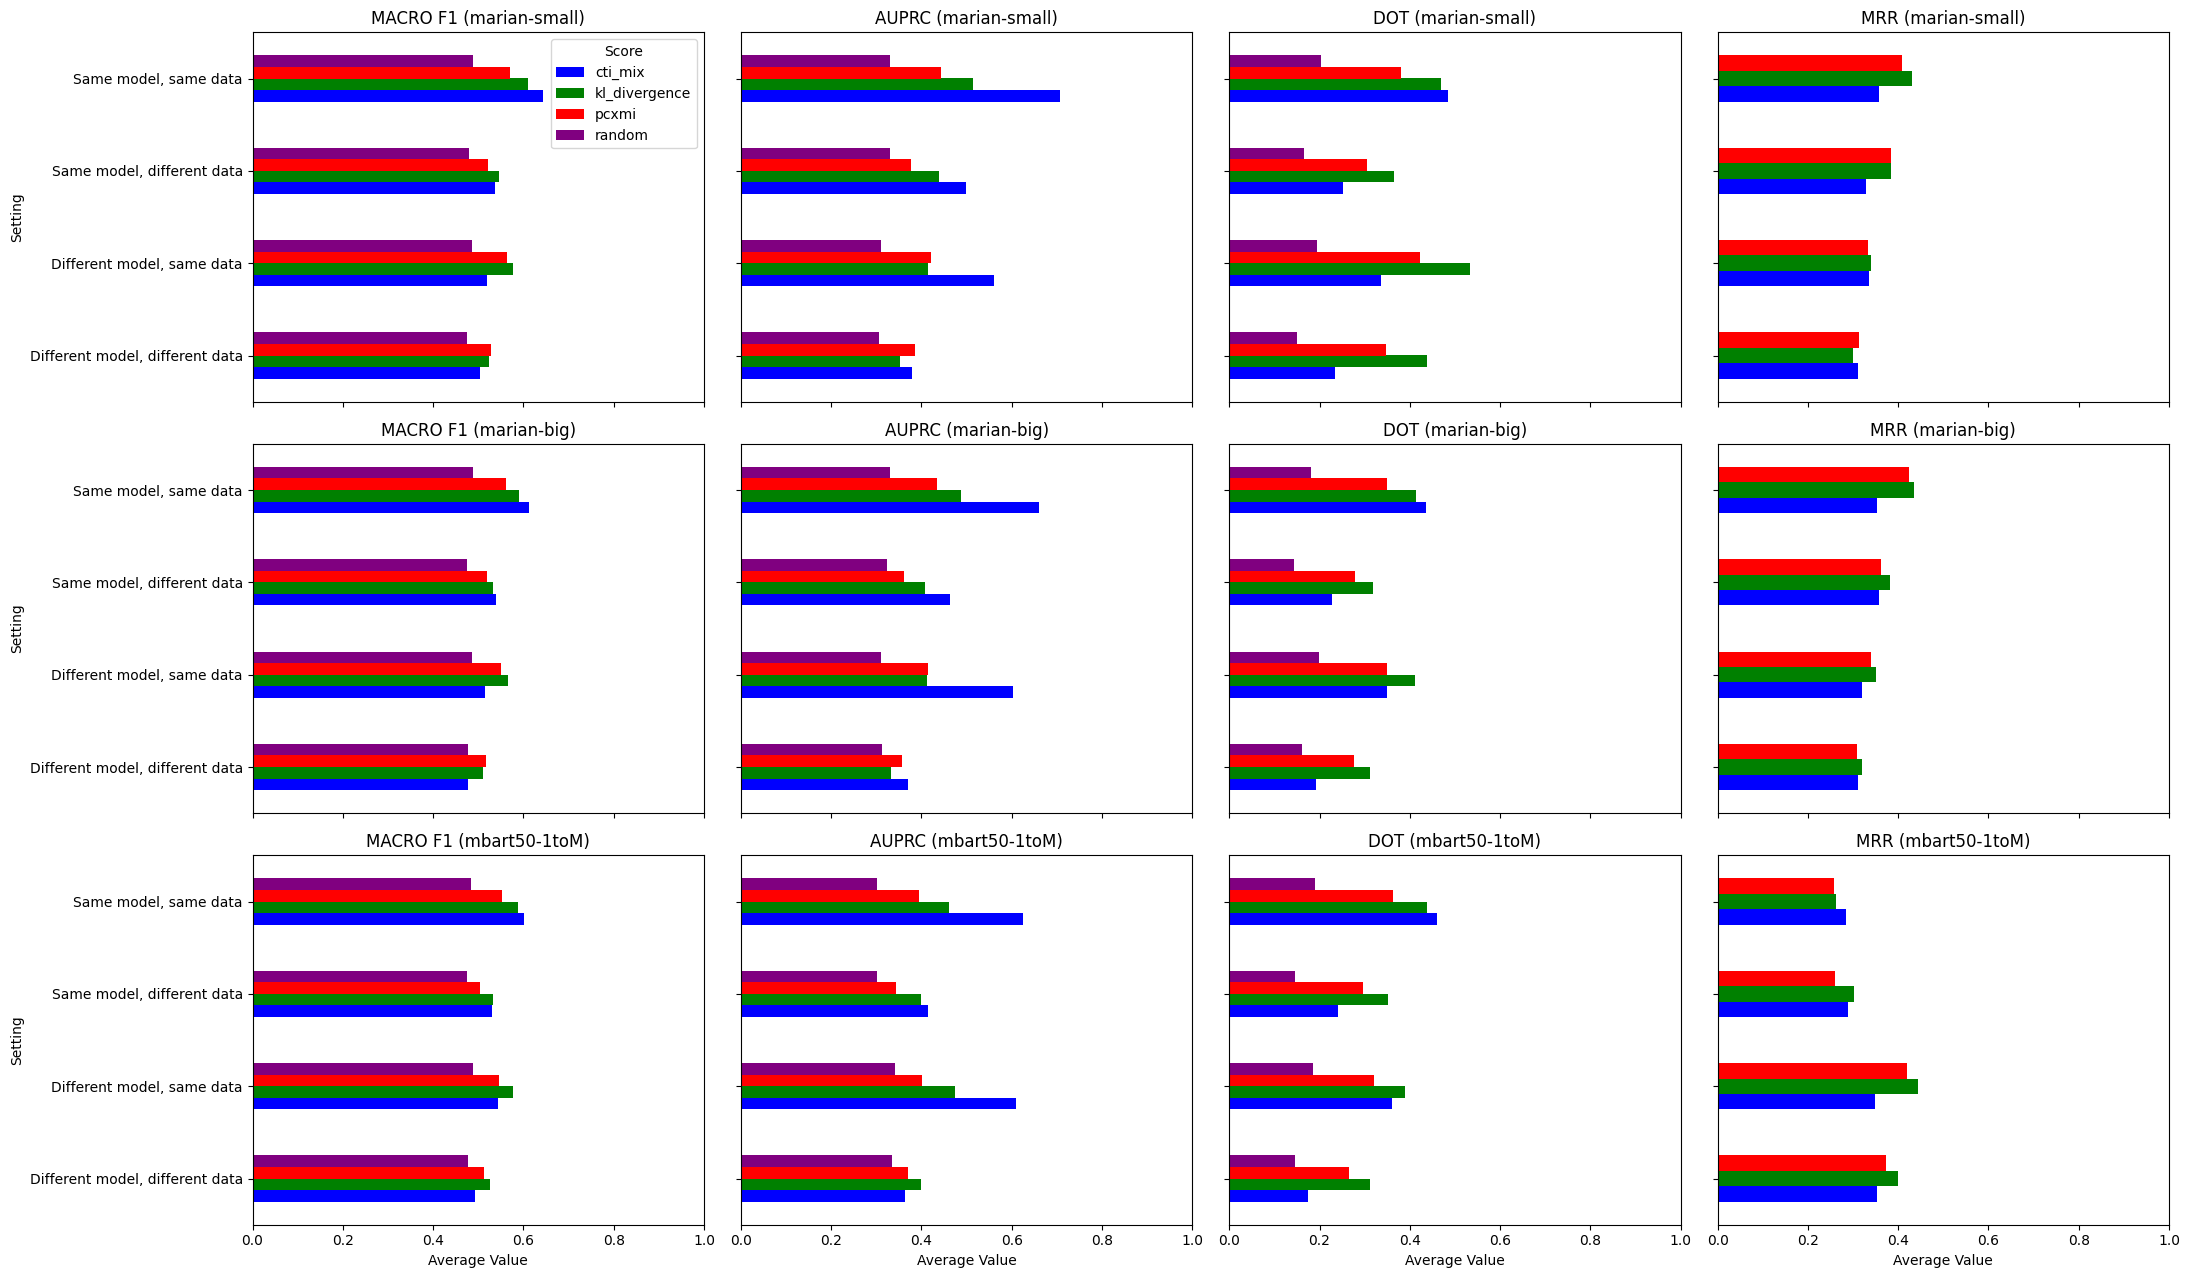

In [3]:
import pandas as pd
from matplotlib import pyplot as plt

# Load the dataset
df = pd.read_csv('../outputs/metrics_evals/random_forest_performance_full.tsv', sep='\t')

def categorize(row):
    if row['train_model'] == row['test_model'] and row['train_type'] == row['test_type']:
        return 'Same model, same data'
    elif row['train_model'] == row['test_model'] and row['train_type'] != row['test_type']:
        return 'Same model, different data'
    elif row['train_model'] != row['test_model'] and row['train_type'] == row['test_type']:
        return 'Different model, same data'
    else:
        return 'Different model, different data'

# Apply the categorization function to the dataframe
df['Setting'] = df.apply(categorize, axis=1)

# Define distinct colors for the scores
colors = ['blue', 'green', 'red', 'purple']

metrics = ['avg_macro_f1', 'avg_auprc', 'avg_dot', 'avg_mrr']
std_metrics = ['std_macro_f1', 'std_auprc', 'std_dot', 'std_mrr']

model_types = df['train_model'].unique()

# Set up the figure and axes again
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(22, 14))

# Plot with the specified colors
for row, model_type in enumerate(model_types):
    model_data = df[df['train_model'] == model_type]
    for col, (metric, std_metric) in enumerate(zip(metrics, std_metrics)):
        if metric == "avg_mrr":
            model_data = model_data[model_data['score'] != 'random']
        means = model_data.groupby(['Setting', 'score'])[metric].mean().unstack()
        #errors = model_data.groupby(['Setting', 'score'])[std_metric].mean().unstack()
        means.plot(kind='barh', ax=axs[row, col], color=colors) # xerr=errors
        axs[row, col].set_title(f"{metric.replace('avg_', '').replace('_', ' ').upper()} ({model_type.replace('-target', '')})")
        axs[row, col].set_xlabel("Average Value")
        axs[row, col].set_xlim(0, 1)
        if col == 0 and row == 0:
            axs[row, col].legend(title='Score')
        else:
            axs[row, col].legend().remove()

for ax in axs.flat:
    ax.label_outer()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [19]:
%%capture

import pandas as pd
from pecore.data_utils import DatasetExample
from pecore.alignment_utils import get_match_from_contrastive_pair

dataset = "disc_eval_mt/anaphora"
model = "mbart50-1toM"
has_target_ctx = True

for metric in ["kl_divergence", "pcxmi", "random"]:
    ex_path = f"../outputs/processed_examples/{dataset.replace('/', '-')}-{model}-scat{'-target' if has_target_ctx else ''}.tsv"
    #cti_path = f"../outputs/scores/{dataset}/{dataset.replace('/', '-')}-{model}-scat{'-target' if has_target_ctx else ''}-cti.tsv"
    cci_path = f"../outputs/scores/{dataset}/{dataset.replace('/', '-')}-{model}-scat{'-target' if has_target_ctx else ''}-tags_{metric}-cci.tsv"
    examples = pd.read_csv(ex_path, sep="\t").to_dict("records")
    examples = [DatasetExample(**ex) for ex in examples]
    #df_cti = pd.read_csv(cti_path, sep="\t")
    df_cci = pd.read_csv(cci_path, sep="\t")

    #scores_cti_df = None
    scores_cci_df = None
    for idx, ex in enumerate(examples):
        #df_cti_ex = df_cti[df_cti["example_idx"] == idx]
        df_cci_ex = df_cci[df_cci["example_idx"] == idx]
        #has_cti = len(df_cti_ex) > 0
        has_cci = len(df_cci_ex) > 0
        if not has_cci:#has_cti and not has_cci:
            continue
        if (
            ex.gold_target_current is None
            or ex.generated_target_current is None
            or ex.gold_target_current_contrast is None
            or ex.generated_target_current_noctx is None
        ):
            raise ValueError(
                "A generated target and a minimal pair of original and contrastive gold targets are required to"
                " compute the example status.\n Provide examples containing these or set --skip_example_status."
            )
        correct_matches = get_match_from_contrastive_pair(
            ref_text=ex.gold_target_current,
            contrast_ref_text=ex.gold_target_current_contrast,
            pred_text=ex.generated_target_current,
        )
        is_correct = 1 if sum(correct_matches) > 0 else 0
        is_flipped = 0
        if is_correct:
            no_ctx_matches = get_match_from_contrastive_pair(
                ref_text=ex.gold_target_current,
                contrast_ref_text=ex.gold_target_current_contrast,
                pred_text=ex.generated_target_current_noctx,
            )
            if sum(no_ctx_matches) == 0:
                is_flipped = 1
        #if has_cti:
        #    df_cti_ex["is_example_flipped"] = is_flipped
        #    if scores_cti_df is None:
        #        scores_cti_df = df_cti_ex
        #    else:
        #        scores_cti_df = pd.concat([scores_cti_df, df_cti_ex], ignore_index=True)
        if has_cci:
            df_cci_ex["is_example_flipped"] = is_flipped
            if scores_cci_df is None:
                scores_cci_df = df_cci_ex
            else:
                scores_cci_df = pd.concat([scores_cci_df, df_cci_ex], ignore_index=True)

    #assert len(df_cti) == len(scores_cti_df)
    assert len(df_cci) == len(scores_cci_df)
    scores_cci_df.to_csv(cci_path, sep="\t", index=False)

In [35]:
scores_cti_df.to_csv(cti_path, sep="\t", index=False)

In [29]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


def plot_scores(dataset, split):
    dataset_name = dataset.replace("/", "-")
    config = "_" + dataset.split("/")[1] if len(dataset.split("/")) > 1 else ""
    # Read the provided data files
    mbart50_df = pd.read_csv(f'../outputs/metrics_evals/{dataset}/{dataset_name}-mbart50-1toM-scat-target-cti-avg-eval.tsv', sep='\t')
    marian_small_df = pd.read_csv(f'../outputs/metrics_evals/{dataset}/{dataset_name}-marian-small-scat-target-cti-avg-eval.tsv', sep='\t')
    marian_large_df = pd.read_csv(f'../outputs/metrics_evals/{dataset}/{dataset_name}-marian-big-scat-target-cti-avg-eval.tsv', sep='\t')

    # Filter the dataframes for the split 'scat_cs_flipped'
    mbart50_filtered = mbart50_df[mbart50_df['split'] == split]
    marian_small_filtered = marian_small_df[marian_small_df['split'] == split]
    marian_large_filtered = marian_large_df[marian_large_df['split'] == split]

    # Extract avg_macro_f1, f1_low, and f1_high for each model
    mbart50_scores = mbart50_filtered[['metric', 'avg_macro_f1', 'f1_low', 'f1_high']]
    marian_small_scores = marian_small_filtered[['metric', 'avg_macro_f1', 'f1_low', 'f1_high']]
    marian_large_scores = marian_large_filtered[['metric', 'avg_macro_f1', 'f1_low', 'f1_high']]

    mbart50_scores["model"] = "mBART-50"
    marian_small_scores["model"] = "OpusMT Small"
    marian_large_scores["model"] = "OpusMT Large"
    all_scores = pd.concat([mbart50_scores, marian_small_scores, marian_large_scores])

    # Reordering models and metrics as per the request
    ordered_models = ["OpusMT Small", "OpusMT Large", "mBART-50"]
    ordered_metrics = ['random', 'ctx_saliency', 'likelihood_ratio', 'pcxmi', 'kl_divergence']
    x = np.arange(len(ordered_models))
    width = 0.11  # Width of bars

    patterns = [ "//" , "\\" , "x", "o", "O", ".", "*" ]

    # Autolabel function to display the exact values above the bars
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height() + 0.03
            ax.annotate('{}'.format(round(height, 2)),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

    fig, ax = plt.subplots(figsize=(8, 4))
    for idx, metric in enumerate(ordered_metrics):
        scores = [all_scores[(all_scores['metric'] == metric) & (all_scores['model'] == model)]['avg_macro_f1'].values[0] 
                for model in ordered_models]
        errors = [(scores[i] - all_scores[(all_scores['metric'] == metric) & (all_scores['model'] == model)]['f1_low'].values[0],
                all_scores[(all_scores['metric'] == metric) & (all_scores['model'] == model)]['f1_high'].values[0] - scores[i])
                for i, model in enumerate(ordered_models)]
        rects = ax.bar(x + idx * width, scores, width, label=metric, yerr=[[errors[j][0] for j in range(len(errors))],
                                                                        [errors[j][1] for j in range(len(errors))]], 
                    capsize=5, align='center', hatch=patterns[idx])
        autolabel(rects)

    # Labels, title, and custom x-axis tick labels, etc.
    ax.set_ylabel('Avg. Macro F1')
    ax.set_xticks(x + width * (len(ordered_metrics) - 1) / 2)
    ax.set_xticklabels(ordered_models)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(ordered_metrics))
    ax.set_ylim(0, 1)

    fig.tight_layout()
    plt.savefig(f"avg_macro_f1_cti_{split}{config}.png")
    plt.show()

In [ ]:
plot_scores("scat", "scat_cs_flipped")
plot_scores("scat", "scat_cs_stable_ok")
plot_scores("scat", "scat_cs_ok")
plot_scores("scat", "scat_cs_all")

In [ ]:
plot_scores("disc_eval_mt/anaphora", "disc_eval_mt_flipped")
plot_scores("disc_eval_mt/anaphora", "disc_eval_mt_ok")
plot_scores("disc_eval_mt/anaphora", "disc_eval_mt_stable_ok")
plot_scores("disc_eval_mt/anaphora", "disc_eval_mt_all")

In [ ]:
plot_scores("disc_eval_mt/lexical-choice", "disc_eval_mt_flipped")
plot_scores("disc_eval_mt/lexical-choice", "disc_eval_mt_ok")
plot_scores("disc_eval_mt/lexical-choice", "disc_eval_mt_stable_ok")
plot_scores("disc_eval_mt/lexical-choice", "disc_eval_mt_all")

In [88]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter(action='ignore')

plt.style.use('ggplot')

metrics_map = {
    "random": "Random",
    "ctx_saliency": "Context Saliency",
    "likelihood_ratio": "Likelihood Ratio",
    "pcxmi": "P-CXMI",
    "kl_divergence": "KL-Divergence",
    "saliency_contrast_prob_diff": "∇ Diff",
    "saliency_kl_divergence": "∇ KL",
    "attention_default": "Attention Mean",
}
dataset_map = {
    "SCAT+": {"path": "scat", "prefix": "scat_cs_"},
    "DiscEval-MT Ana.": {"path": "disc_eval_mt/anaphora", "prefix": "disc_eval_mt_"},
    "DiscEval-MT Lex.": {"path": "disc_eval_mt/lexical-choice", "prefix": "disc_eval_mt_"},
}

# Autolabel function to display the exact values above the bars
def autolabel(ax, rects, errors):
    for rect, error in zip(rects, errors):
        height = rect.get_height() + error[1]
        ax.annotate('{}'.format(round(rect.get_height(), 2)).lstrip('0'),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

def plot_scores_per_model(
    model_name,
    splits,
    step="cti",
    ordered_datasets=["SCAT+", "DiscEval-MT Ana.","DiscEval-MT Lex."],
    ordered_metrics=None,
    width=0.13,
    e2e=None,
    metrics_map=metrics_map,
    dataset_map=dataset_map,
    patterns = [ "//" , "\\" , "x", "o", "."],
):

    if ordered_metrics is None:
        if step == "cti":
            ordered_metrics = ["Random", 'Context Saliency', 'Likelihood Ratio', 'P-CXMI', 'KL-Divergence']
        elif step == "cci":
            ordered_metrics = ["Random", "∇ Diff", "∇ KL", "Attention Mean", "Attention Best"]
    if e2e is not None and step != "cci":
        raise ValueError("e2e only for CCI!")

    dfs = {}
    for dataset in ordered_datasets:
        d_path = dataset_map[dataset]['path']
        e2e_path_str = "" if e2e is None else "e2e/"
        e2e_metric_str = "" if e2e is None else f"tags_{e2e}-"
        file_id = f"{d_path}/{e2e_path_str}{d_path.replace('/', '-')}-{model_name}-{e2e_metric_str}{step}-avg-eval.tsv"
        dfs[dataset] = pd.read_csv(f'../outputs/metrics_evals/{file_id}', sep='\t')

    fig, axs = plt.subplots(figsize=(10, 2.4), ncols=len(splits))

    for i, (split, ax) in enumerate(zip(splits, axs)):

        scores = []
        for dname, df in dfs.items():
            df_filtered = df[df['split'] == dataset_map[dname]["prefix"] + split]
            df_scores = df_filtered[['metric', 'avg_macro_f1', 'f1_low', 'f1_high']]
            df_scores["dataset"] = dname
            scores.append(df_scores)
        all_scores = pd.concat(scores)

        if "Attention Best" in ordered_metrics and step == "cci":
            attn_scores = all_scores[(all_scores["metric"].str.startswith("attention_")) & (all_scores["metric"].str.endswith("h"))]
            attn_name = attn_scores[attn_scores["avg_macro_f1"] == attn_scores["avg_macro_f1"].max()]["metric"].values[0]
            print(f"Attention Best = {attn_name}")
            metrics_map = {**metrics_map, **{attn_name: "Attention Best"}}
        all_scores = all_scores.replace(metrics_map)
        x = np.arange(len(ordered_datasets))

        for idx, metric in enumerate(ordered_metrics):
            scores = [all_scores[(all_scores['metric'] == metric) & (all_scores['dataset'] == dataset)]['avg_macro_f1'].values[0] 
                    for dataset in ordered_datasets]
            errors = [(scores[i] - all_scores[(all_scores['metric'] == metric) & (all_scores['dataset'] == dataset)]['f1_low'].values[0],
                    all_scores[(all_scores['metric'] == metric) & (all_scores['dataset'] == dataset)]['f1_high'].values[0] - scores[i])
                    for i, dataset in enumerate(ordered_datasets)]
            rects = ax.bar(x + idx * width, scores, width, label=metric, yerr=[[errors[j][0] for j in range(len(errors))],
                                                                            [errors[j][1] for j in range(len(errors))]], 
                        capsize=5, align='center', hatch=patterns[idx])
            autolabel(ax, rects, errors)

        # Labels, title, and custom x-axis tick labels, etc.
        ax.set_xticks(x + width * (len(ordered_metrics) - 1) / 2)
        ax.set_xticklabels(ordered_datasets)
        ax.set_ylim(0, 1)
        if i == 0:
            handles, labels = ax.get_legend_handles_labels()
            ax.set_ylabel('Avg. Macro F1')
        if i != 0:
            ax.set(yticklabels=[])
            ax.tick_params(left=False)
        ax.autoscale_view('tight')

    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.08), ncol=len(ordered_metrics))
    fig.tight_layout(w_pad=0.3)
    e2e_label = "" if e2e is None else f"_{e2e}"
    plt.savefig(f"avg_macro_f1_{step}_{model_name}{e2e_label}.pdf", bbox_inches='tight')
    plt.show()

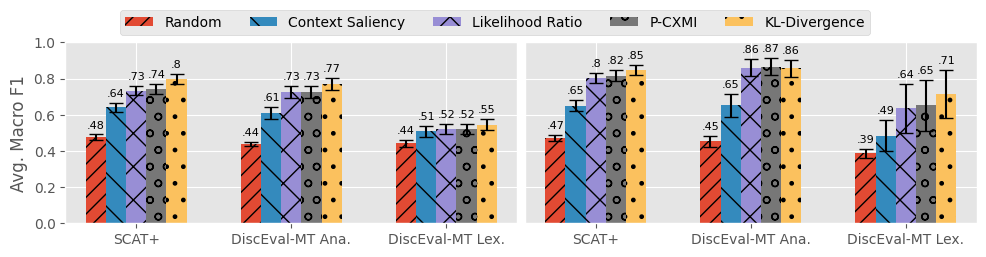

In [89]:
plot_scores_per_model("marian-big-scat-target", ["all", "flipped"])

Attention Best = attention_4l_4h
Attention Best = attention_2l_8h


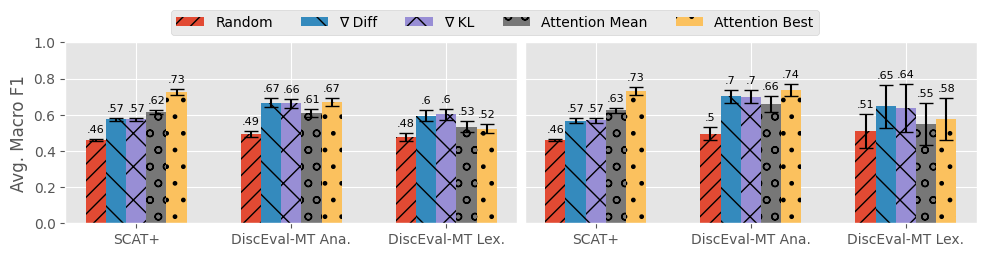

In [100]:
plot_scores_per_model("marian-big-scat-target", ["all", "flipped"], step="cci")

Attention Best = attention_2l_8h
Attention Best = attention_2l_8h


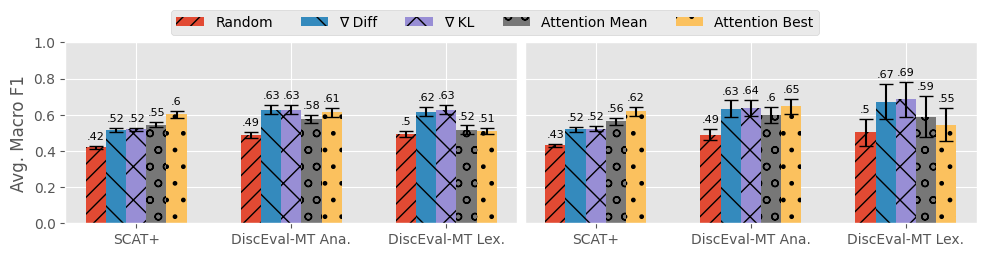

In [91]:
plot_scores_per_model("marian-big-scat-target", ["all", "flipped"], step="cci", e2e="kl_divergence")

Attention Best = attention_4l_5h
Attention Best = attention_4l_5h


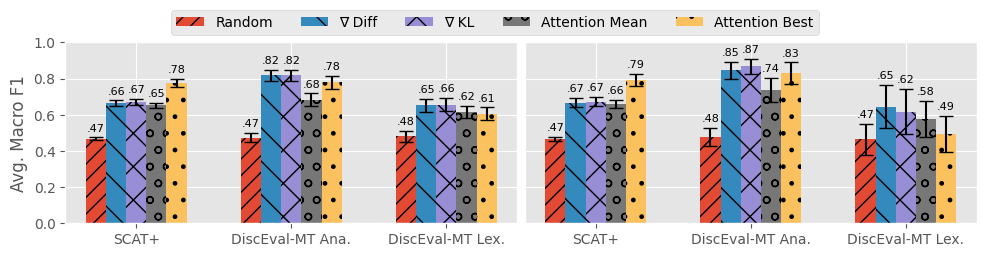

In [102]:
plot_scores_per_model("marian-big-scat", ["all", "flipped"], step="cci")

Attention Best = attention_4l_5h
Attention Best = attention_4l_5h


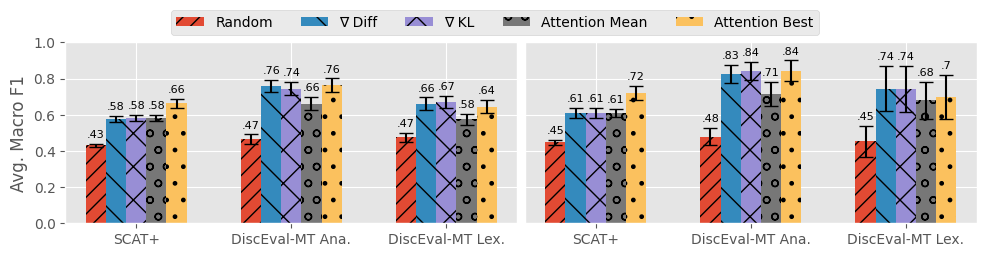

In [101]:
plot_scores_per_model("marian-big-scat", ["all", "flipped"], step="cci", e2e="kl_divergence")

In [27]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import warnings
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import os
warnings.simplefilter(action='ignore')

plt.style.use('ggplot')

scores_map = {
    "Random": "random",
    "Context Saliency": "ctx_saliency",
    "Likelihood Ratio": "likelihood_ratio",
    "P-CXMI": "pcxmi",
    "KL-Divergence": "kl_divergence",
    "∇ Diff": "saliency_contrast_prob_diff",
    "∇ KL": "saliency_kl_divergence",
    "Attention Mean": "attention_default",
    "Attention 2L8H": "attention_2l_8h",
    "Attention 4L5H": "attention_4l_5h",
    "Attention Best": "attention_best",
}
datasets_map = {
    "SCAT+": "scat",
    "DiscEval-MT Ana.": "disc_eval_mt/anaphora",
    "DiscEval-MT Lex.": "disc_eval_mt/lexical-choice"
}
metrics_map = {
    "macro_f1": "Macro F1",
    "auprc": "AUPRC",
    "mrr": "MRR",
    "dot": "Dot Product"
}

colors = ['pink', 'lightblue', 'lightgreen', 'lightcoral', 'peachpuff']

ordered_datasets = ["SCAT+", "DiscEval-MT Ana.","DiscEval-MT Lex."]

def get_score_id(score, bn):
    if score != "Attention Best":
        return scores_map[score]
    if bn is not None:
        return scores_map["Attention " + bn]
    else:
        return scores_map["Attention Best"]


def prepare_ax(ax, split, datasets, metrics, selected_metric, setting, model_name, i, bn):
    has_e2e_medians = False
    for dataset in datasets:
        for idx, metric in enumerate(metrics):
            data = pd.read_csv(f"../outputs/metrics_evals/{datasets_map[dataset]}/all_metric_scores/{datasets_map[dataset].replace('/', '-')}-{model_name}-{setting}-avg-{get_score_id(metric, bn)}-{split}-scores.tsv", sep="\t")
            position = metrics.index(metric) + (len(metrics) + 1) * datasets.index(dataset)
            bplot = ax.boxplot(data[selected_metric], positions=[position], widths=0.6, patch_artist=True, labels=[metric], vert=True)#, showmeans=True)
            bplot["boxes"][0].set_facecolor(colors[idx])
            bplot['medians'][0].set(color="red", linewidth=1.5)
            kl_path = f"../outputs/metrics_evals/{datasets_map[dataset]}/all_metric_scores/{datasets_map[dataset].replace('/', '-')}-{model_name}-tags_kl_divergence-{setting}-avg-{get_score_id(metric, bn)}-{split}-scores.tsv"
            if setting == "cci" and os.path.exists(kl_path):
                has_e2e_medians = True
                data_kl = pd.read_csv(kl_path, sep="\t")
                kl_median = data_kl[selected_metric].median()
                ax.hlines(y=kl_median, xmin=position-0.35, xmax=position+0.35, linewidth=2, color='black', linestyle="dotted")
            #ax.set_xticks([])
            #ax.set_xticklabels([])
    ax.set_xticks([2, 8, 14])
    ax.set_xticklabels(["SCAT+", "DiscEval-MT Ana.", "DiscEval-MT Lex."])#metric for _ in ordered_datasets for metric in ordered_metrics], rotation=45, ha='right')
    if i == 0:
        ax.set_ylabel(metrics_map[selected_metric])
    if i != 0:
        ax.set(yticklabels=[])
        ax.tick_params(left=False)
    ax.autoscale_view('tight')
    return has_e2e_medians

def plot_scores_per_model_boxplot(
    model_name,
    splits,
    selected_metric="macro_f1",
    datasets=ordered_datasets,
    metrics=None,
    setting="cti",
    sizes=(10, 2.4),
    with_target=False,
    best_names=None
):

    if metrics is None:
        if setting == "cti":
            metrics = ["Random", 'Context Saliency', 'Likelihood Ratio', 'P-CXMI', 'KL-Divergence']
        elif setting == "cci":
            metrics = ["Random", "∇ Diff", "∇ KL", "Attention Mean", "Attention Best"]
    with_target_plot = "target" not in model_name and with_target
    ncols =len(splits) * 2 if with_target_plot else len(splits)
    if best_names is None:
        best_names = [None] * ncols
    fig, axs = plt.subplots(figsize=sizes, ncols=ncols)
    if ncols == 1:
        axs = [axs]
    if with_target_plot:
        for i, (split, ax, bn) in enumerate(zip(splits, axs[:len(splits)], best_names[:len(splits)])):
            has_e2e_medians = prepare_ax(ax, split, datasets, metrics, selected_metric, setting, model_name, i, bn)
        target_model_name = model_name + "-target"
        for i, (split, ax, bn) in enumerate(zip(splits, axs[len(splits):], best_names[len(splits):]), start=len(splits)):
            has_e2e_medians_tgt = prepare_ax(ax, split, datasets, metrics, selected_metric, setting, target_model_name, i, bn)
        has_e2e_medians = has_e2e_medians or has_e2e_medians_tgt
    else:
        for i, (split, ax, bn) in enumerate(zip(splits, axs, best_names)):
            has_e2e_medians = prepare_ax(ax, split, datasets, metrics, selected_metric, setting, model_name, i, bn)
    legend_elements = [
        Patch(facecolor=color, label=metric)
        for color, metric in zip(colors, metrics)
    ]
    if has_e2e_medians:
        legend_elements += [Line2D([0], [0], color='black', lw=2, linestyle="dotted", label='E2E median')]
    fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.10), ncol=len(metrics) + 1 if has_e2e_medians else len(metrics))
    plt.tight_layout()
    plt.savefig(f"{selected_metric}_{setting}_{model_name}{'+tgt' if with_target_plot else ''}_box.pdf", bbox_inches='tight')
    plt.show()

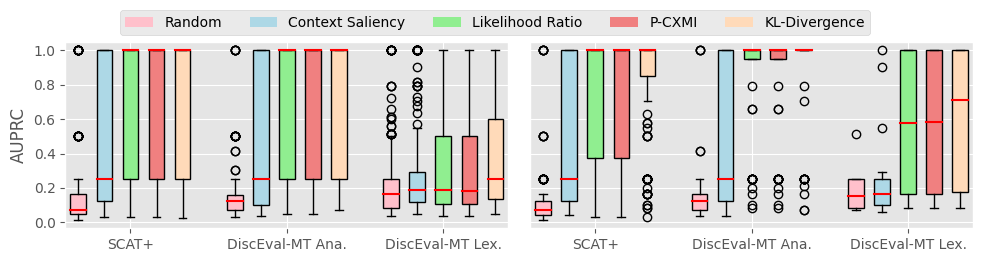

In [19]:
plot_scores_per_model_boxplot("marian-big-scat-target", ["all", "flipped"], selected_metric="auprc")

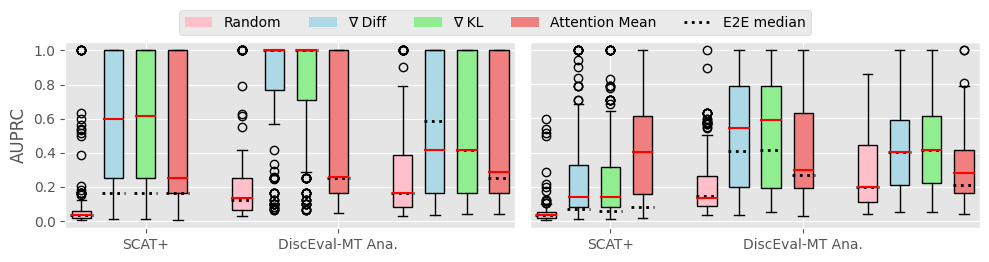

In [35]:
plot_scores_per_model_boxplot("marian-big-scat", ["all"], selected_metric="auprc", setting="cci", with_target=True, metrics = ["Random", "∇ Diff", "∇ KL", "Attention Mean"])

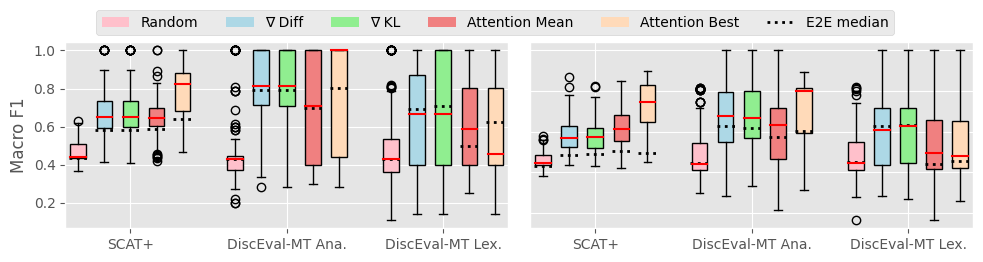

In [10]:
plot_scores_per_model_boxplot("marian-big-scat", ["all"], selected_metric="macro_f1", setting="cci", with_target=True, best_names=["4L5H", "2L8H"])

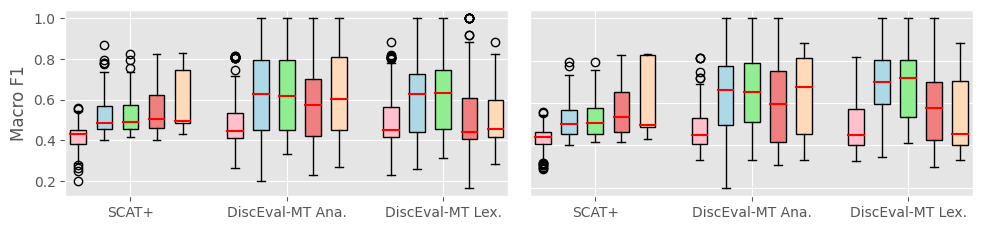

In [35]:
plot_scores_per_model_boxplot("marian-big-scat-target-tags_kl_divergence", ["all", "flipped"], selected_metric="macro_f1", setting="cci")